# COVID-19 Dataset
Kaggle Links: [US Vaccine Tracker + Population Stats](https://www.kaggle.com/peretzcohen/us-vaccine-tracker/data#Your-turn_)

Using 2019 population data from the U.S. Census and COVID-19 vaccine records from Our World In Data on GitHub to visualize and forecast vaccine progression as it relates to total state population.
***

*import necessary modules*

In [7]:
import pandas as pd
import os

import matplotlib.pyplot as plt
plt.style.use('ggplot')

***
__Extract__<br>
Using 2019 Census data from kaggle and daily-updated covid-19 vaccination data from *Our World In Data*'s GitHub page 

In [8]:
cwd = os.getcwd()
pop_data = pd.read_csv(cwd + "\\data\\" + "2019_Census_US_Population_Data_By_State_Lat_Long.csv")
vacc_data = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv")

***
__Transform__

Combine population by state and total vaccinations by state

In [9]:
vacc_data_state = vacc_data[['date', 'location', 'people_vaccinated']].copy()
pop_data_state = pop_data[['STATE', 'POPESTIMATE2019']].copy()

vacc_data_state.dropna(subset=['people_vaccinated'], inplace=True)
pop_data_state.dropna(subset=['POPESTIMATE2019'], inplace=True)

pop_data_state.rename(columns={'STATE': 'location'}, inplace=True)
pop_data_state.rename(columns={'POPESTIMATE2019': 'population'}, inplace=True)

merged = pd.merge(vacc_data_state, pop_data_state, how='left', on=['location'])
merged.dropna(subset=['population'], inplace=True)

merged['location'] = merged['location'].astype(str)
merged['percent'] = merged.people_vaccinated / merged.population * 100

merged.columns = merged.columns.str.strip()
merged.date = pd.to_datetime(merged.date, format='%Y-%m-%d')

***
__Visualizations__<br>
Modify <code>state_name</code> on line 16 to determine which state's vaccine records you would like to further understand. All following cells use this specified state as reference. Use <code>plot_state(state_name, vis)</code> or <code>plot_all()</code> on line 17 to plot data from a single state, or all data combined.

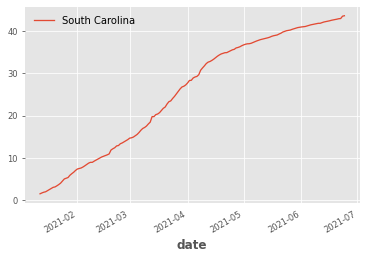

In [67]:
vis = merged[['date', 'percent', 'location']]

def plot_state(state_name, vis):
    # limiting vis data to a single state
    vis = vis.loc[vis['location'] == state_name]
    vis = vis[['date', 'percent']]
    vis.plot(kind='line', x='date', y='percent', label=state_name)

def plot_all(vis):
    groups = vis.groupby('location')
    for name, group in groups:
        plt.plot(group['date'], group['percent'], label=name)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## customize visualizations
state_name = 'South Carolina'
plot_state(state_name, vis)
#plot_all()

***
__Predictions__

In [74]:
state = merged.loc[merged['location'] == state_name]
state = state[['date', 'location', 'percent']]

In [75]:
from darts import TimeSeries
import darts.models as models
from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis

get_data = state[['date', 'percent']].copy()

# fill missing dates with padded vaccination percent data. 0.0 values would otherwise disrupt the model
reset = pd.date_range(start=get_data.date.min(), end=get_data.date.max())
get_data = get_data.set_index('date').reindex(reset).fillna(method='pad').rename_axis('date').reset_index()

series = TimeSeries.from_dataframe(get_data, 'date', 'percent')
# split train/test down the middle of the dataset [get_data.date.median()]
train, test = series.split_before(pd.Timestamp('2021-06-01'))

def test_models(models, train, test):
    best = None
    lowest = float('inf')
    for model in models:
        model.fit(train)
        forecast = model.predict(len(test))
        #print("model {} obtains MAPE: {:.2f}%".format(model, mape(test, forecast)))
        err = mape(test, forecast)
        if err < lowest:
            lowest = err
            best = model
    print('Best model ({}) obtains MAPE: {:.2f}%'.format(best, lowest))
    return best

best_model = test_models([models.ARIMA(), models.ExponentialSmoothing(), models.Theta(), models.AutoARIMA()], train, test)

C:\Users\ramis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
[2021-06-25 05:02:18,880] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 70.
[2021-06-25 05:02:18,881] INFO | darts.models.theta | Theta model inferred seasonality of training series: 0
[2021-06-25 05:02:18,881] INFO | darts.models.theta | Theta model inferred seasonality of training series: 0


Best model (ARIMA(12, 1, 0)) obtains MAPE: 0.28%


***
__Visualize Forecasts__

<ipython-input-76-530bf0b1c62d>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:0.0f}%'.format(x) for x in plt.gca().get_yticks()])


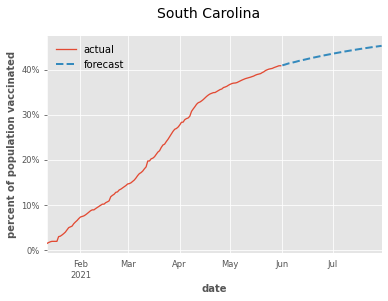

In [76]:
#predict next 60 days of vaccinations
pred = best_model.predict(60)

train.plot(label='actual')
pred.plot(label='forecast', lw=2, linestyle='dashed')

plt.suptitle(state.location.iloc[0], fontsize='14')
plt.ylabel('percent of population vaccinated', fontsize='10')
plt.gca().set_yticklabels(['{:0.0f}%'.format(x) for x in plt.gca().get_yticks()]) 
plt.xlabel('date', fontsize='10')
plt.legend()